### Import OpenVisus and add one utility function to load images from disk or network

In [8]:
import sys,os,numpy,cv2
from   skimage.metrics import structural_similarity as ssim
from   PIL import Image,ImageChops
from   urllib.request import urlopen
import matplotlib.pyplot as plt
import tempfile
import ssl # this is needed for APPLE  (urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed )

%matplotlib inline

# if you have OpenVisus binary dir somewhere not in site-packages
from OpenVisus import *

# utility to load images
def LoadImage(filename):
    if filename.startswith("http"):
        filename=urlopen(filename,context=ssl.SSLContext() ) 
        size=int(filename.info()['Content-Length'])
    else:
        size=os.stat(filename).st_size
    ret=Image.open(filename)
    ret=numpy.asarray(ret)
    print("Loaded",filename,"size",size)
    return [ret,size]

def ShowImage(data):
    fig =  plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()
    
def rmse(predictions, targets):
    return numpy.sqrt(((predictions - targets) ** 2).mean())
    
# function to test db compression and show diff
def TestCompression(compression,data=None, filename=next(tempfile._get_candidate_names())+".idx",filter=None):
    
   # Here I'm assuming I have RGB data uint8 (i.ei bitsperblock=15 corresponds to 2^15*3/1024=96KB)
    bitsperblock=15

    # one file per dataset
    blocksperfile=-1    
 
    filename_bin="./" + filename + ".bin"
    db=CreateIdx(
        url=filename, 
        filename_template=filename_bin, 
        dim=2,data=data, 
        bitsperblock=bitsperblock, 
        blocksperfile=-1,
        filters=[] if filter is None else [filter])
    
    print("Created db",filename)
    
    if filter is not None:
        print("Computing filter...")
        db.computeFilter(db.getField(),4096)
    
    print("Compressing dataset...")
    db.compressDataset(compression) 
    idx_size=os.stat(filename_bin).st_size 
    print("Compression ratio in comparison to source data {:.2f}".format(idx_size/src_size)) 
    
    # read a little preview
    idx_preview=LoadDataset(filename).read(x=[0,src_preview.shape[1]],y=[0,src_preview.shape[0]])
    if filter is not None:
        idx_preview=idx_preview[:,:,0:3] # last channels are just coefficients
        
    print("RMSE (preview):", rmse(src_preview,idx_preview))
    
    # show diff1 using image difference
    diff1=numpy.array(ImageChops.difference(Image.fromarray(src_preview), Image.fromarray(idx_preview)))
    print("diff [min, max, mean]:", [numpy.min(diff1), numpy.max(diff1), numpy.mean(diff1)])
    

    # show diff2 using structure similarity
    __score__,diff2 = ssim(src_preview, idx_preview, full=True, multichannel=True)
    print("sm [min, max, mean]:", [numpy.min(diff2), numpy.max(diff2), numpy.mean(diff2)])
    diff2=(diff2+1.0)*0.5
    diff2=(diff2*255.0).astype(numpy.uint8)
    
    ShowImage(idx_preview)
    ShowImage(diff1)
    ShowImage(diff2)
    
    # remove all temporary files
    os.remove(filename)
    os.remove(filename_bin)    
    
print("OpenVisus imported and utils added")

OpenVisus imported and utils added


### Open one source image which will be compared to IDX compressed one

/usr/local/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Loaded <http.client.HTTPResponse object at 0x107490910> size 83615445
Loaded <http.client.HTTPResponse object at 0x105e411d0> size 100060372
Src image loaded SrcSize 79 MB shape (10000, 10000, 3) dtype uint8


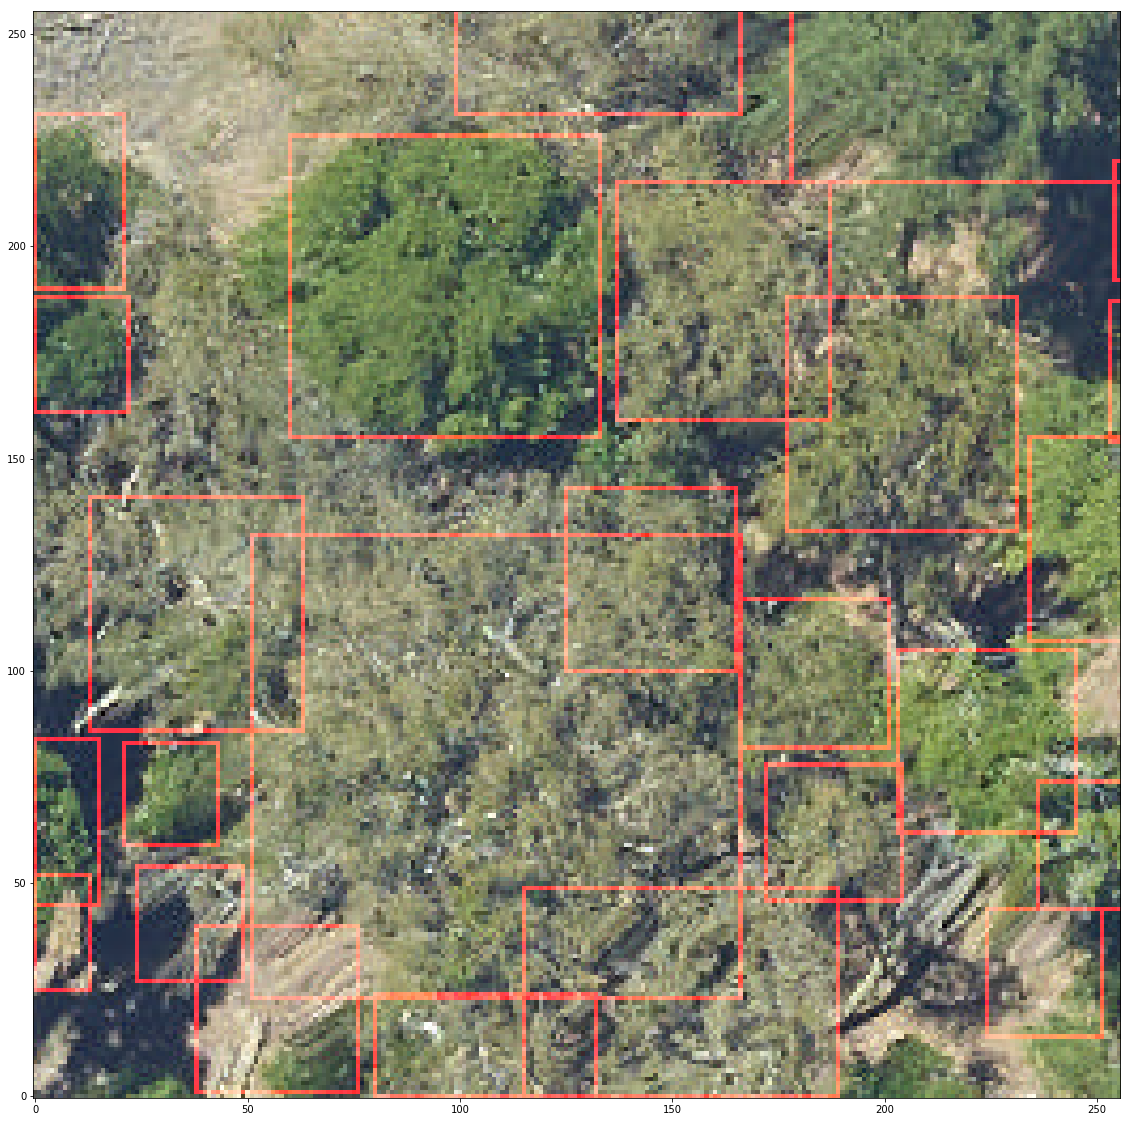

In [2]:
test="neon"

if test=="neon":
    # show red lines (annotations from 'rasterize' file)
    src,src_size=LoadImage("https://github.com/sci-visus/OpenVisus/releases/download/test__compression/2019_OSBS_5_402000_3284000_image.tif")
    ras,ras_size=LoadImage("https://github.com/sci-visus/OpenVisus/releases/download/test__compression/2019_OSBS_5_402000_3284000_image_rasterized.tif")
    src=numpy.copy(src)
    src[:,:,0][ras>0]=255
    preview_size=256
    src_preview=src[0:preview_size,0:preview_size,:]
    
if test=="david":
    src,src_size=LoadImage("https://is4-ssl.mzstatic.com/image/thumb/Purple3/v4/ed/b1/08/edb108f6-aa0c-e3ad-97e5-00a15329b5eb/mzl.oqyivrxl.png/643x0w.jpg")
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src
    
if test=="hdr":
    src,src_size=LoadImage("https://color.viewsonic.com/asset-files/images/journal/High-Dynamic-Range.jpg")
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src    
    
print("Src image loaded","SrcSize",int(src_size/(1024*1024)),"MB","shape",src.shape,"dtype",src.dtype)
ShowImage(src_preview)

### Loss-less zip compression: idx binary file is too big, obviously no artifacts

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 3.22
RMSE (preview): 0.0
diff [min, max, mean]: [0, 0, 0.0]
sm [min, max, mean]: [1.0, 1.0, 1.0]


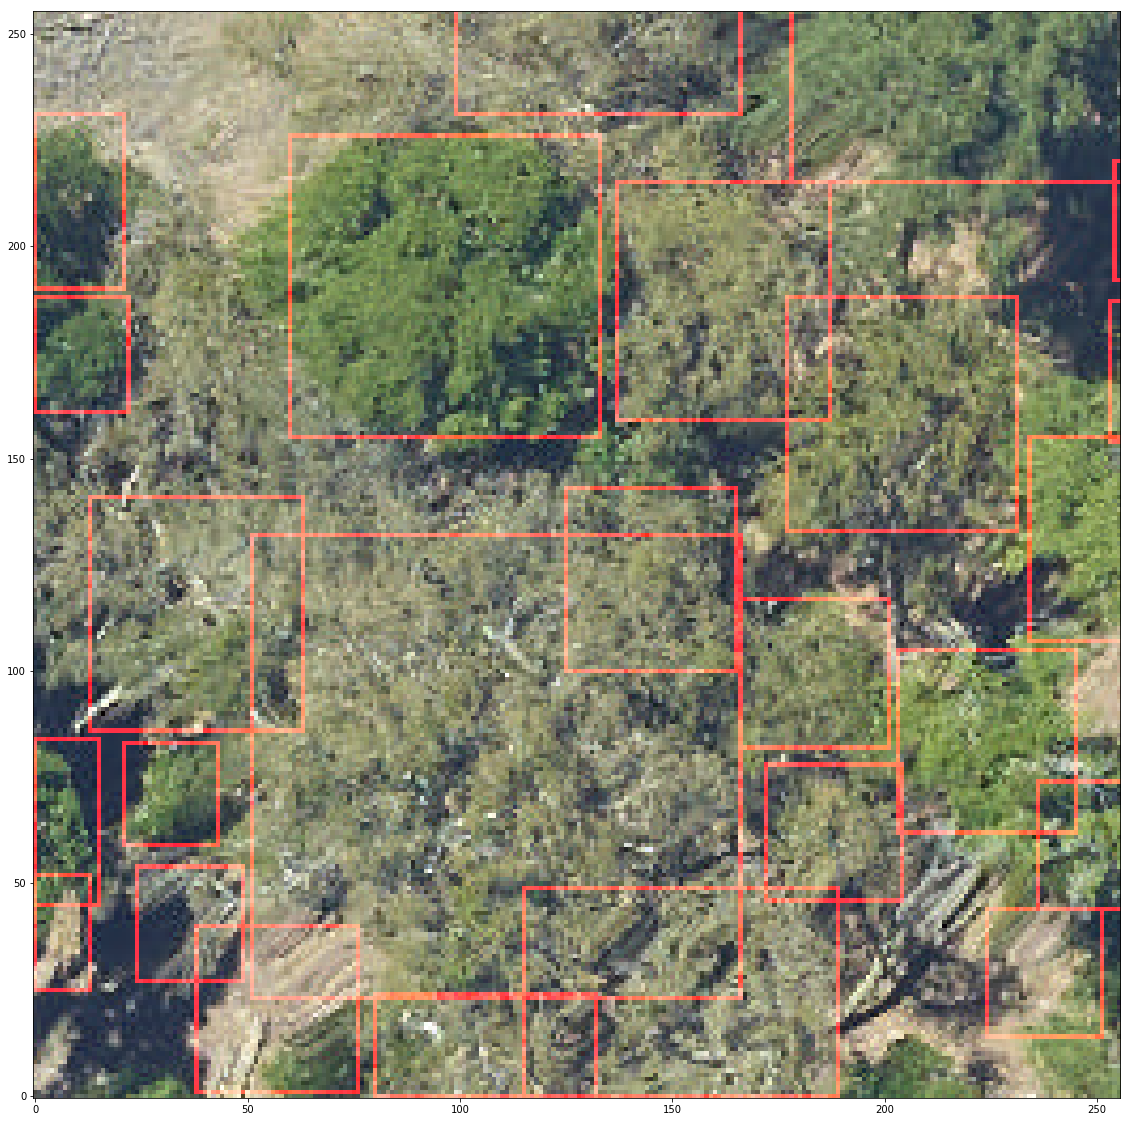

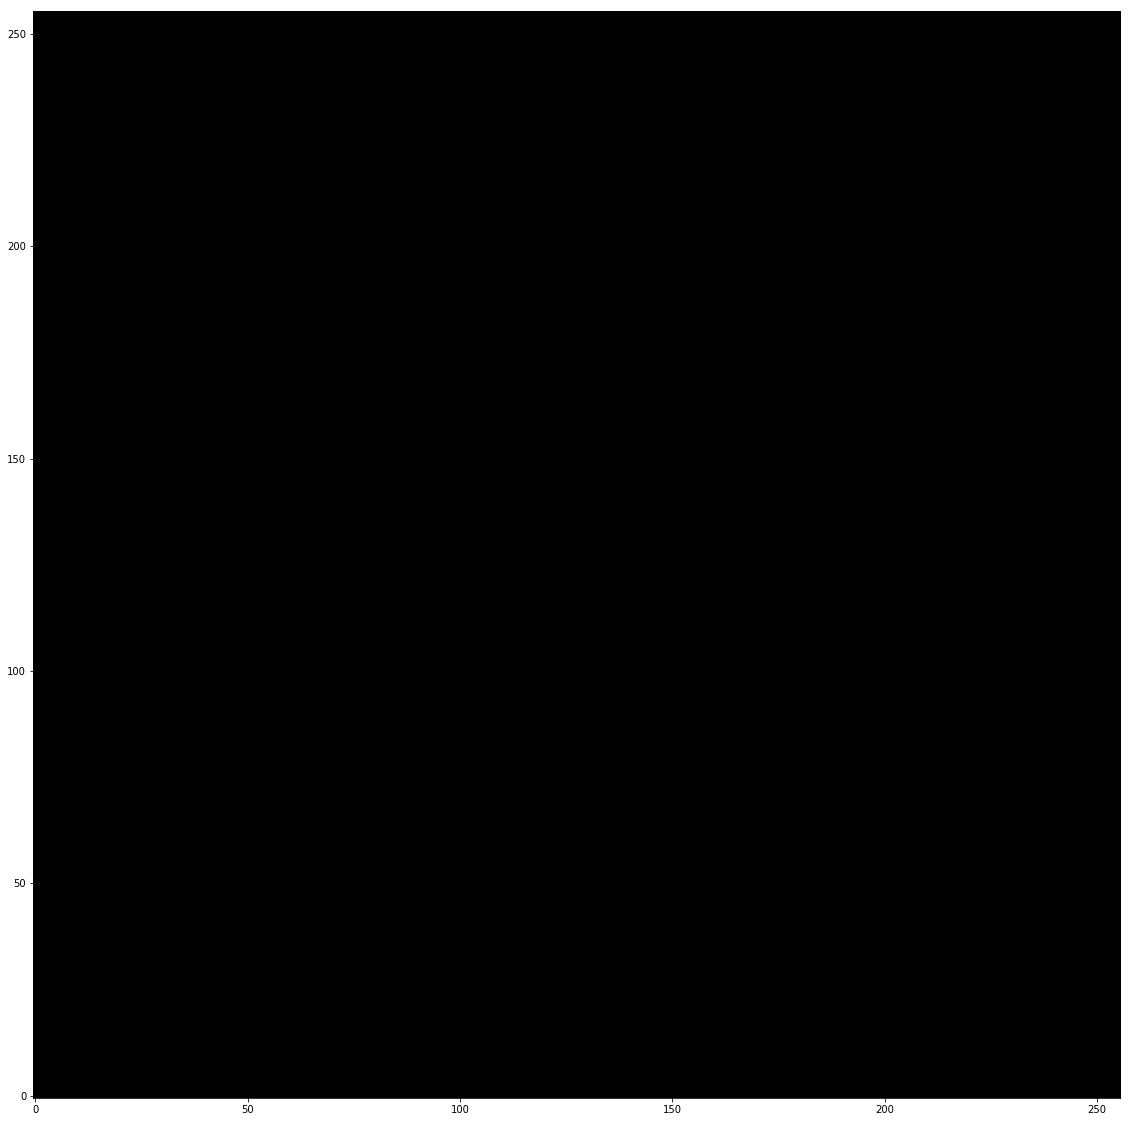

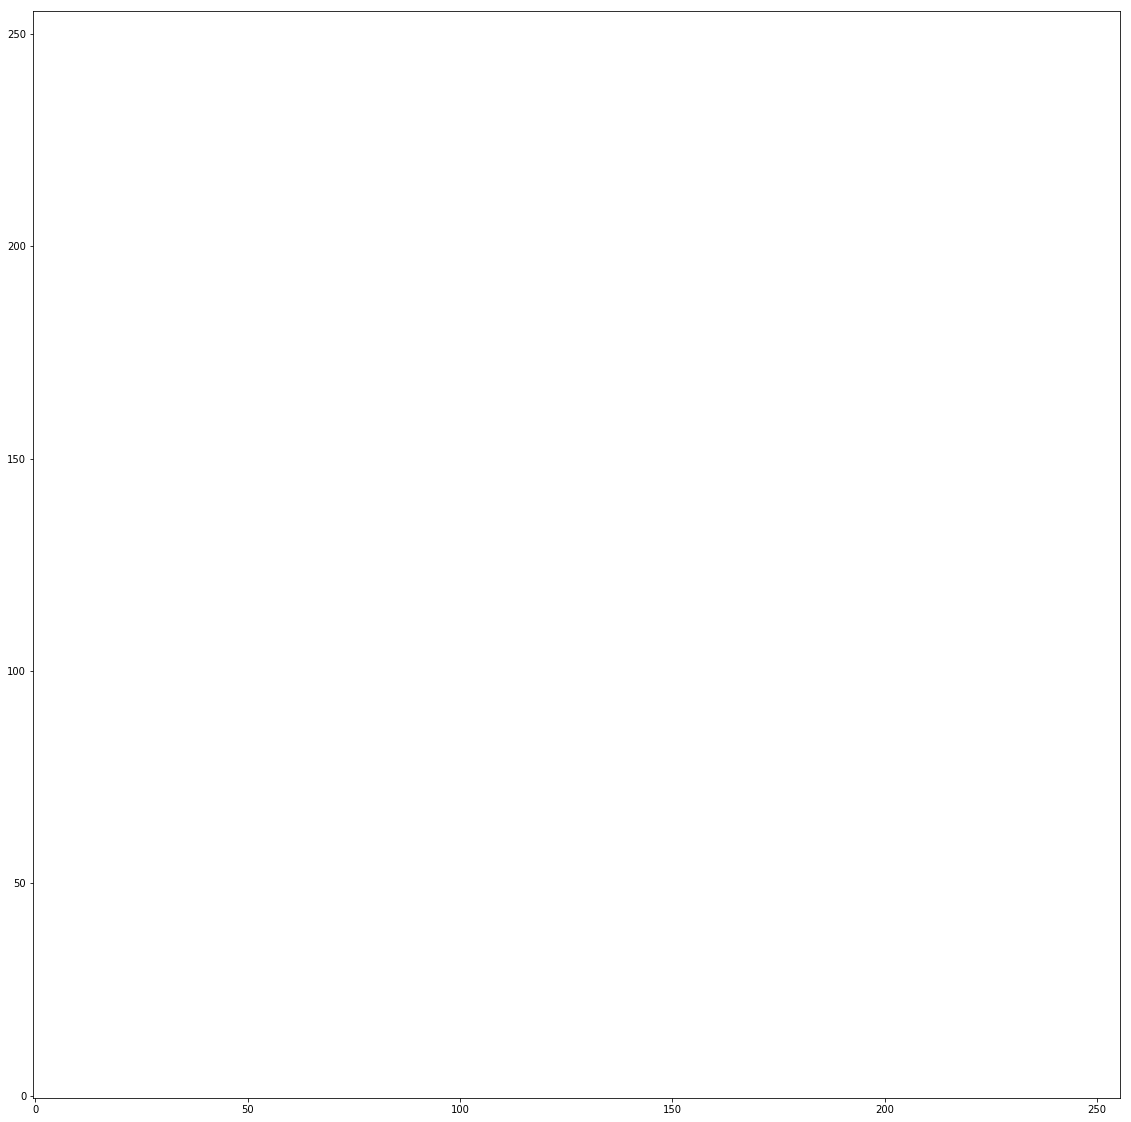

In [9]:
TestCompression(["zip"],data=src)

### JPEG good 420, unusable, tons of artifacts everywere (good compression ratio). Unusable

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 0.45
RMSE (preview): 8.609518854193661
diff [min, max, mean]: [0, 169, 12.705795288085938]
sm [min, max, mean]: [-0.056823355042329285, 0.9924809784962946, 0.8206011344150657]


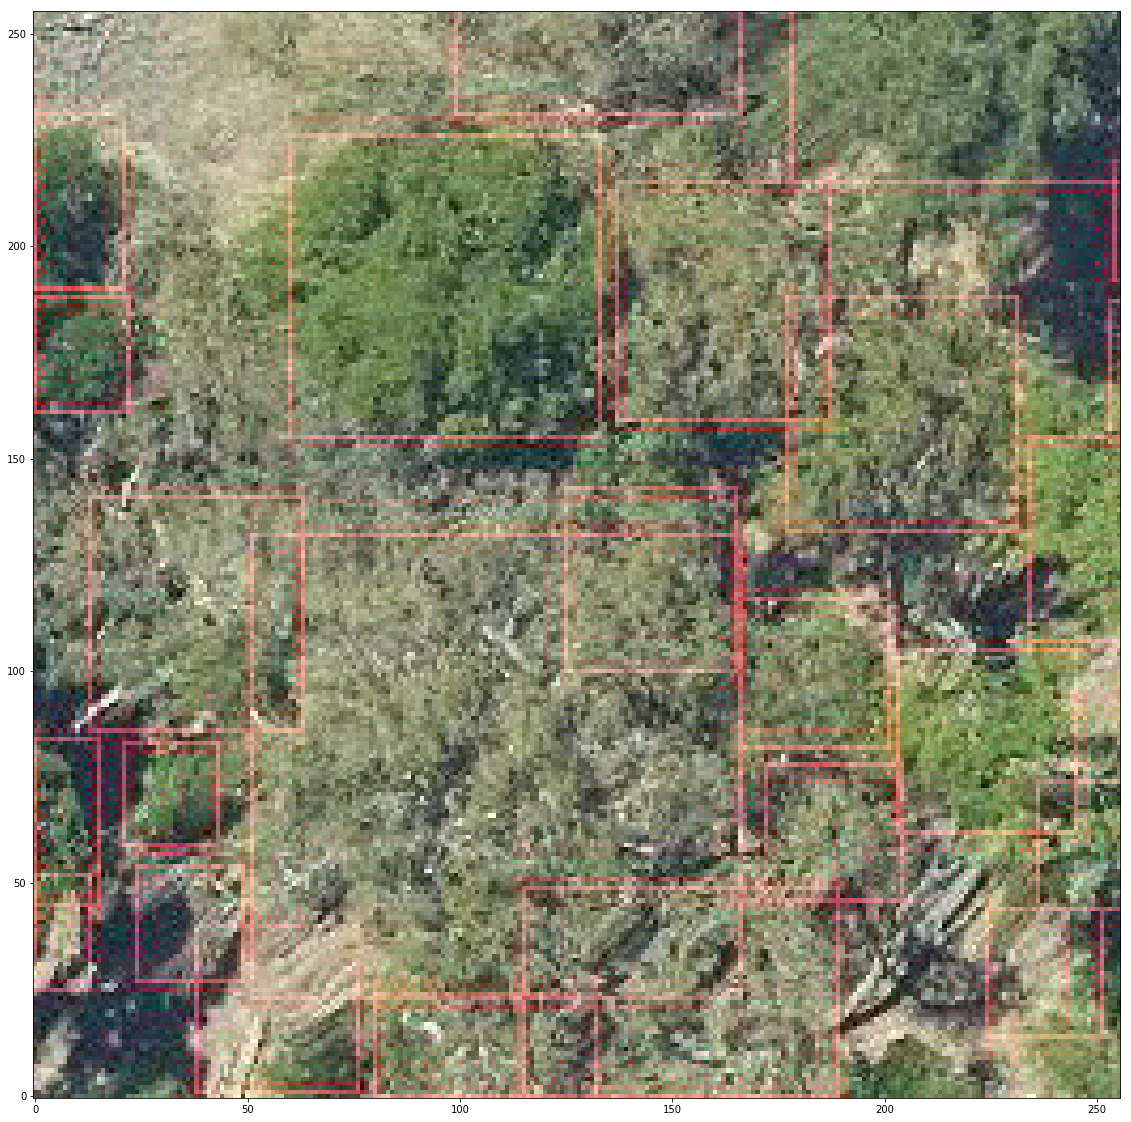

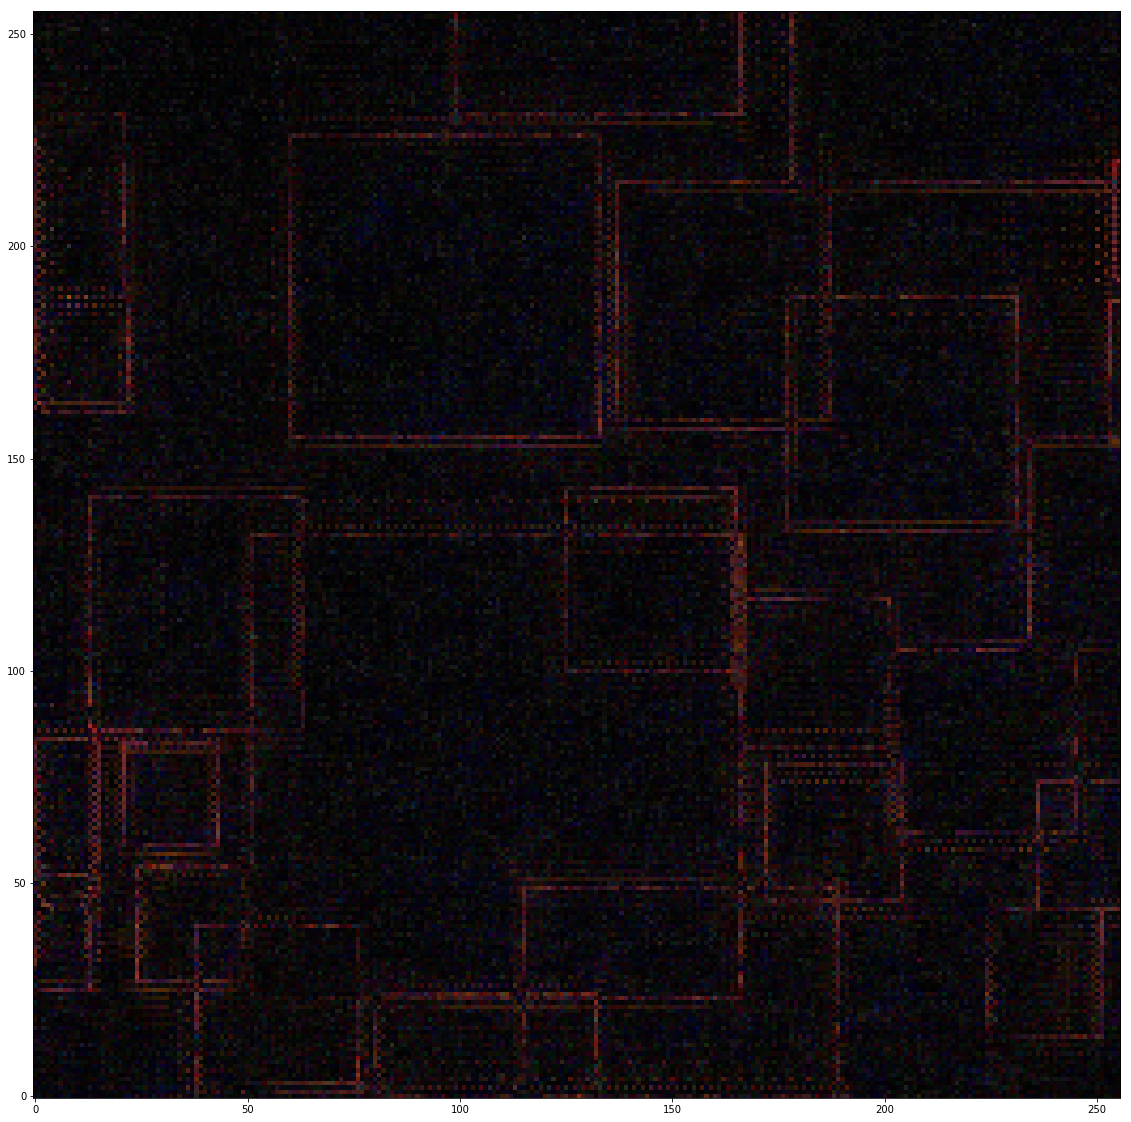

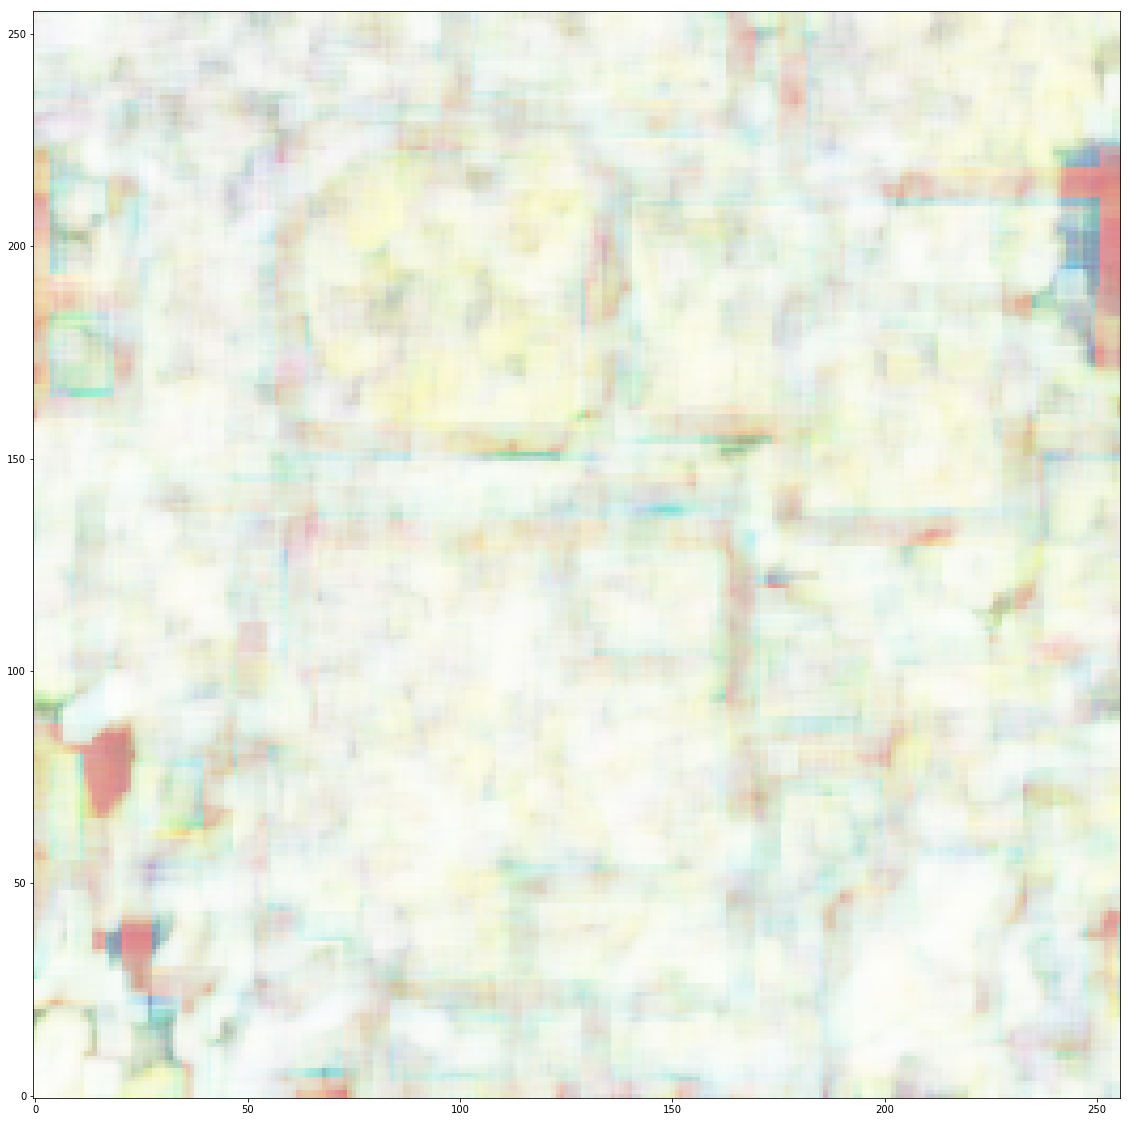

In [10]:
TestCompression(["jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE"],data=src)

### jpeg good 444. Random noise spread everywhere but low frequency. Kind of usable?

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 0.56
RMSE (preview): 8.123761361415447
diff [min, max, mean]: [0, 111, 9.442560831705729]
sm [min, max, mean]: [0.13888174178490742, 0.997938712048828, 0.877841153200356]


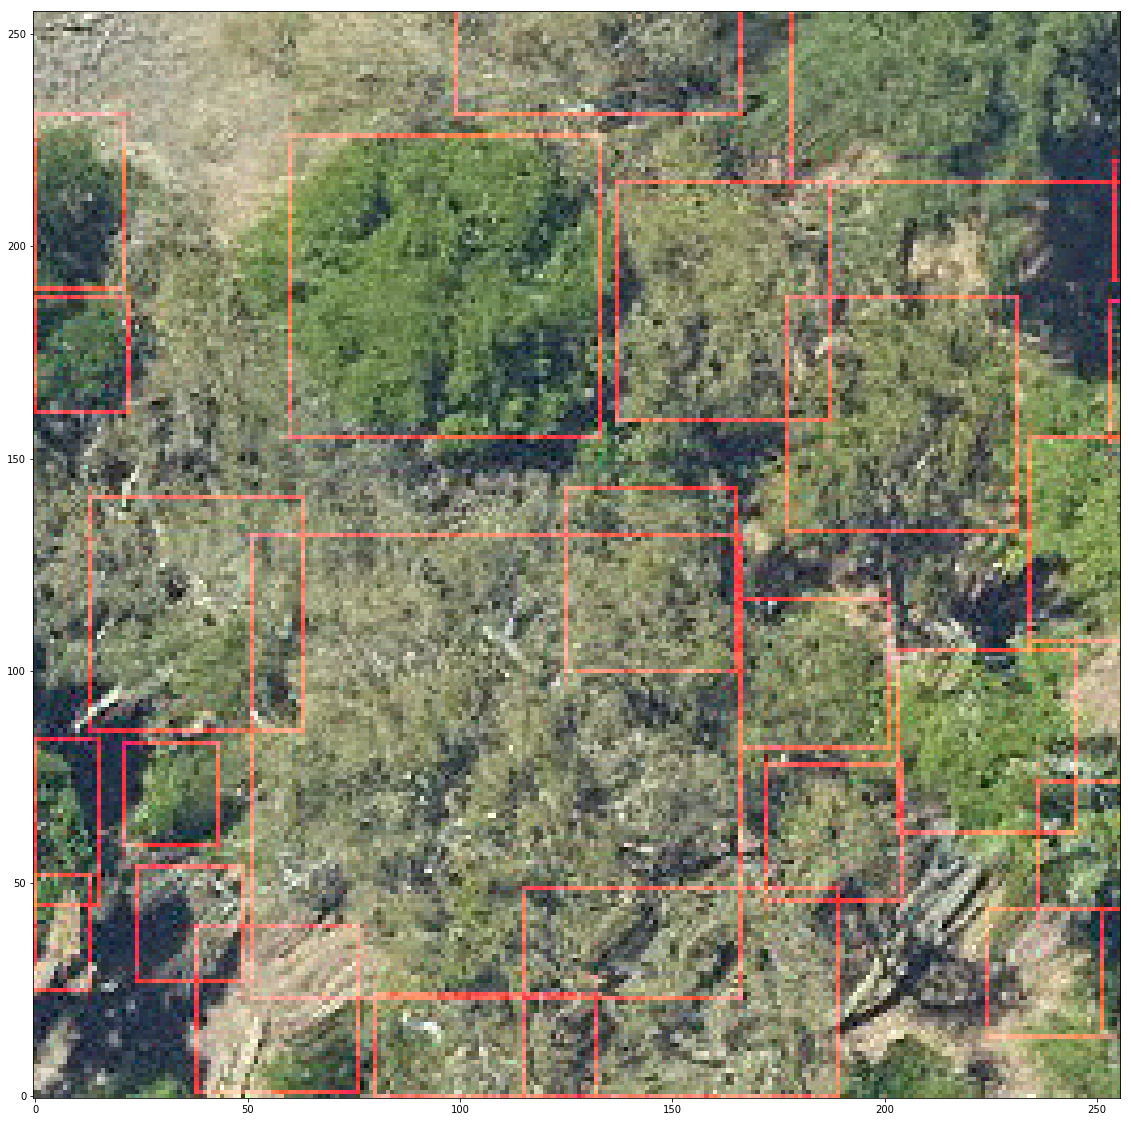

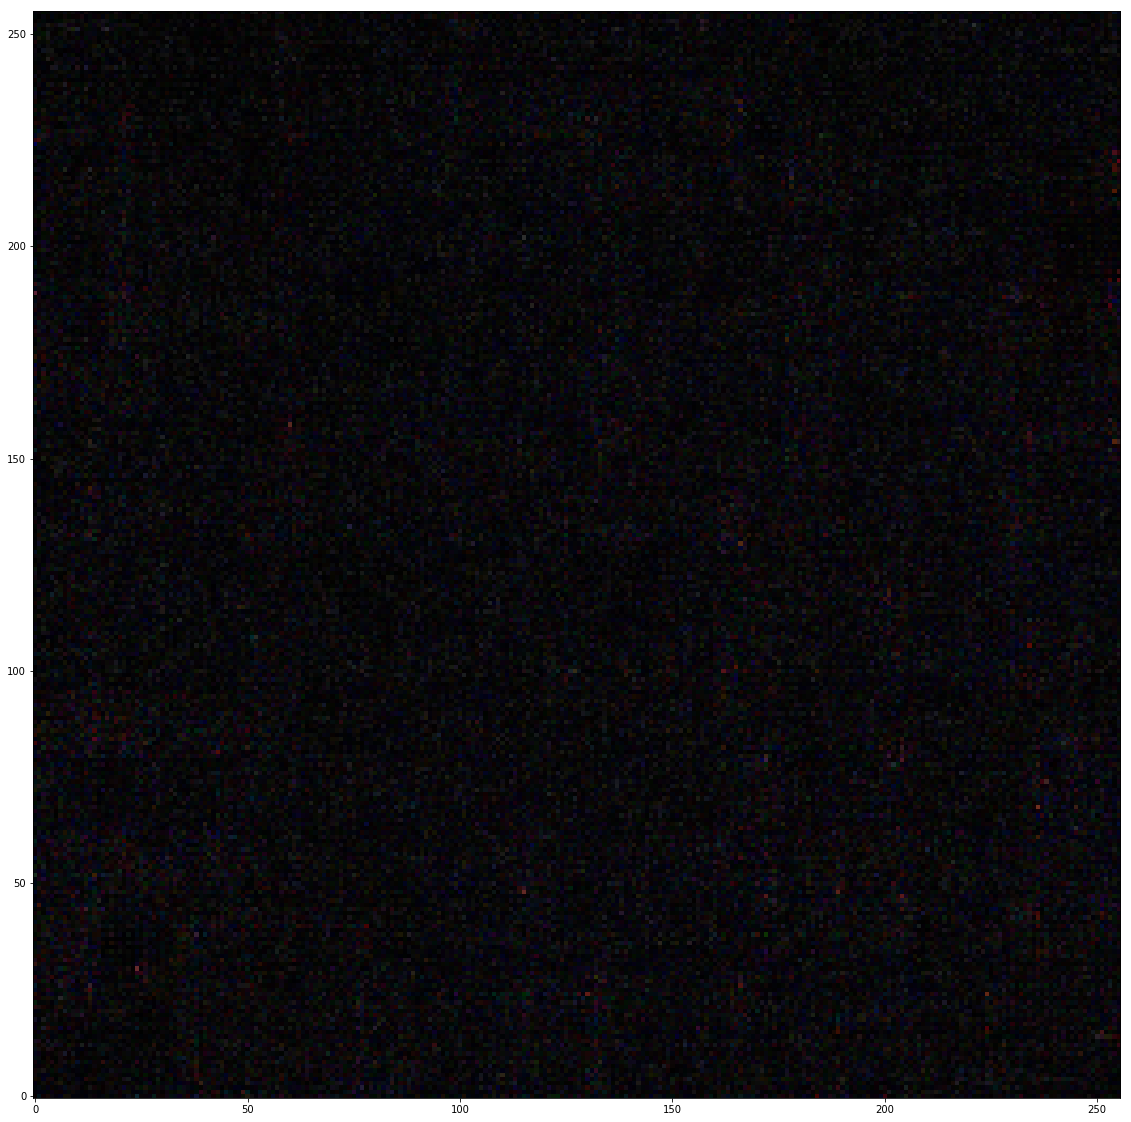

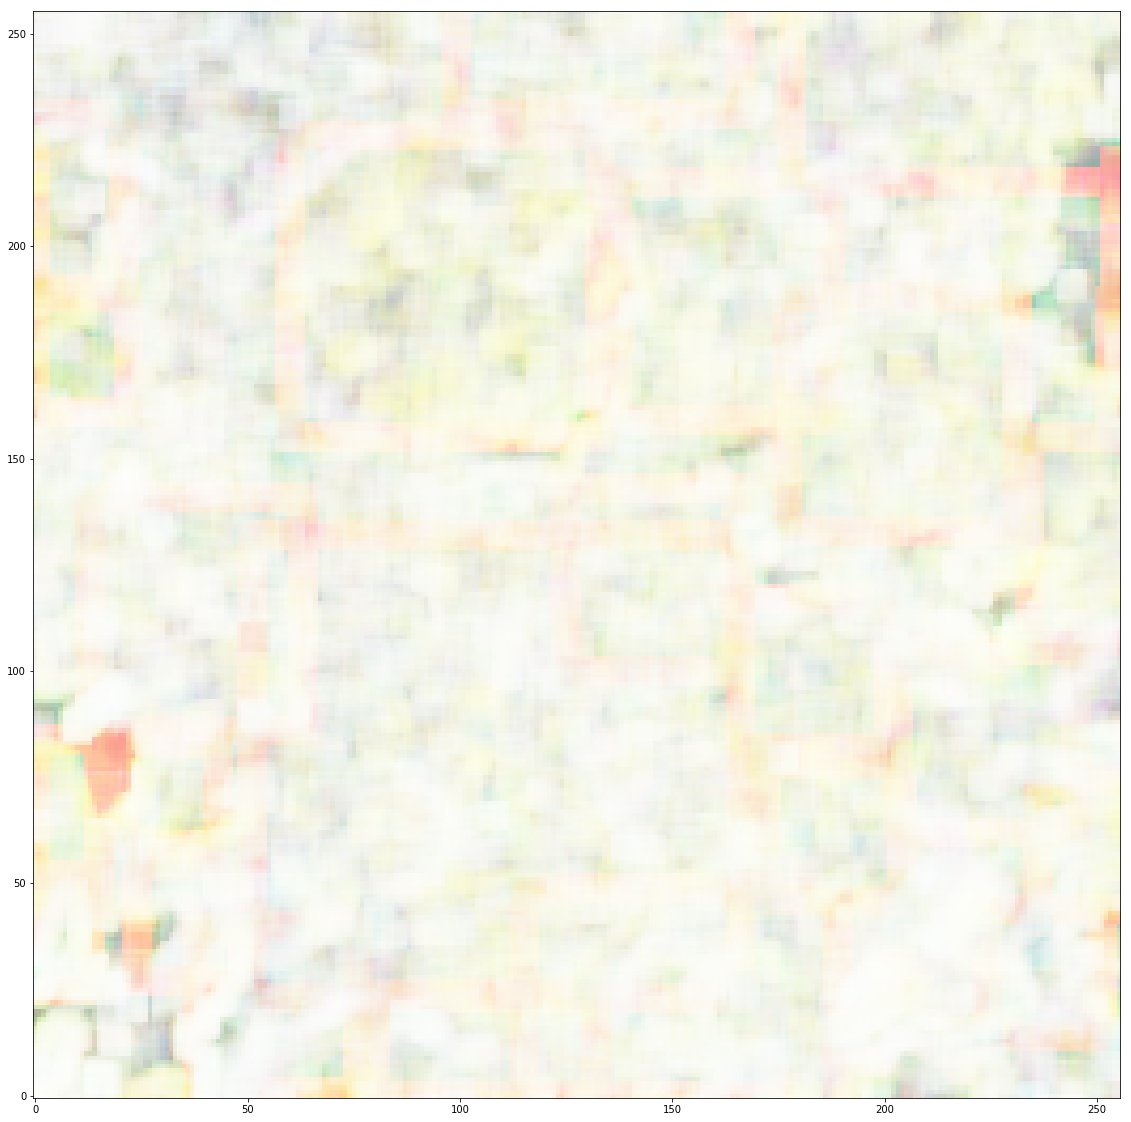

In [14]:
TestCompression(["jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE"],data=src)

### jpeg superb 420. Unusable tons of artifacts.

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 1.38
RMSE (preview): 7.233750296439391
diff [min, max, mean]: [0, 145, 9.021082560221354]
sm [min, max, mean]: [0.02063075474690399, 0.9973000257521073, 0.8923002123361444]


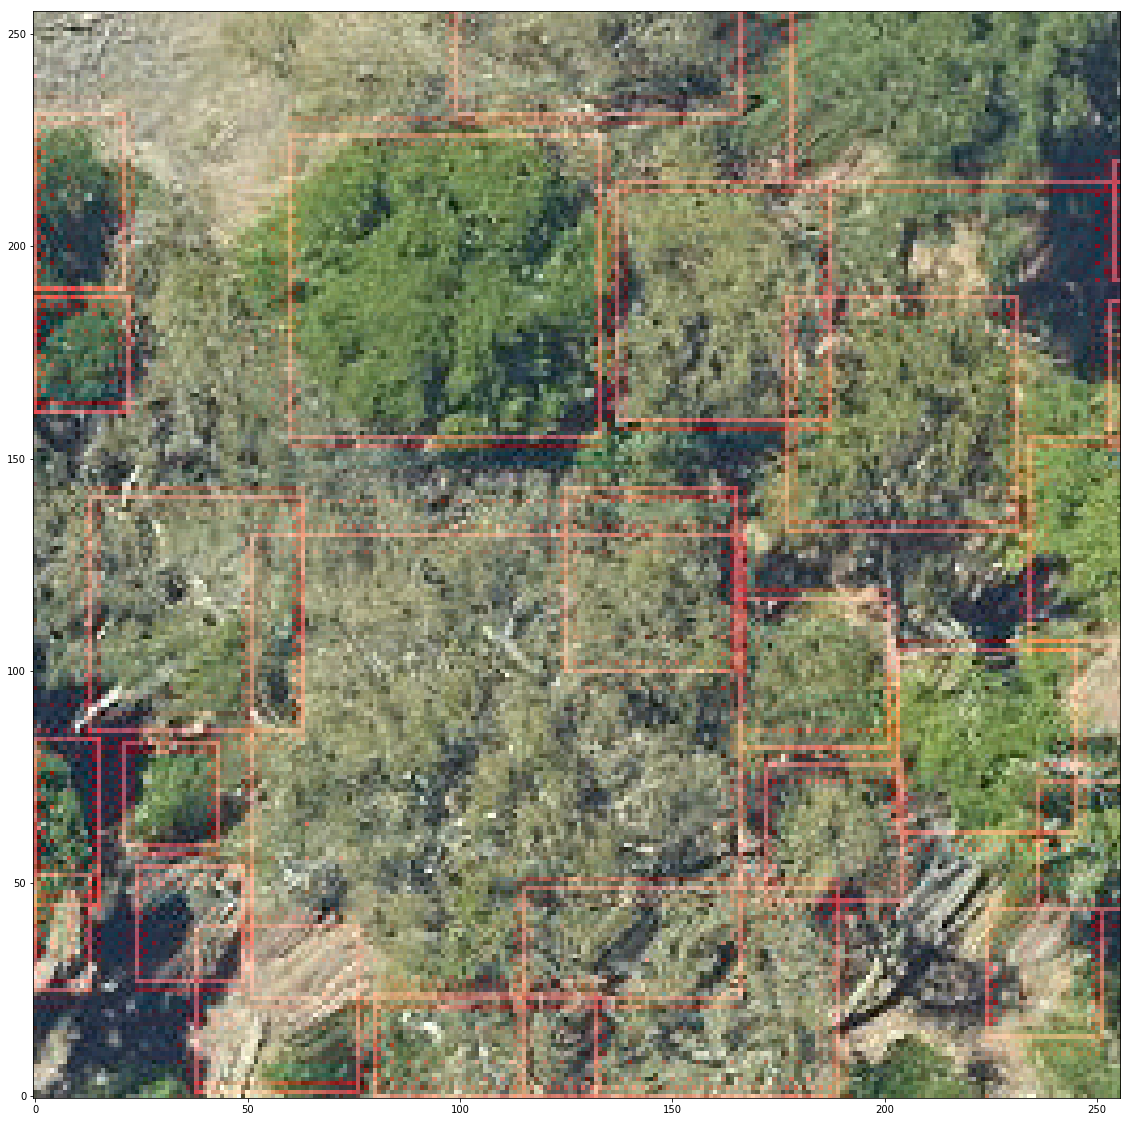

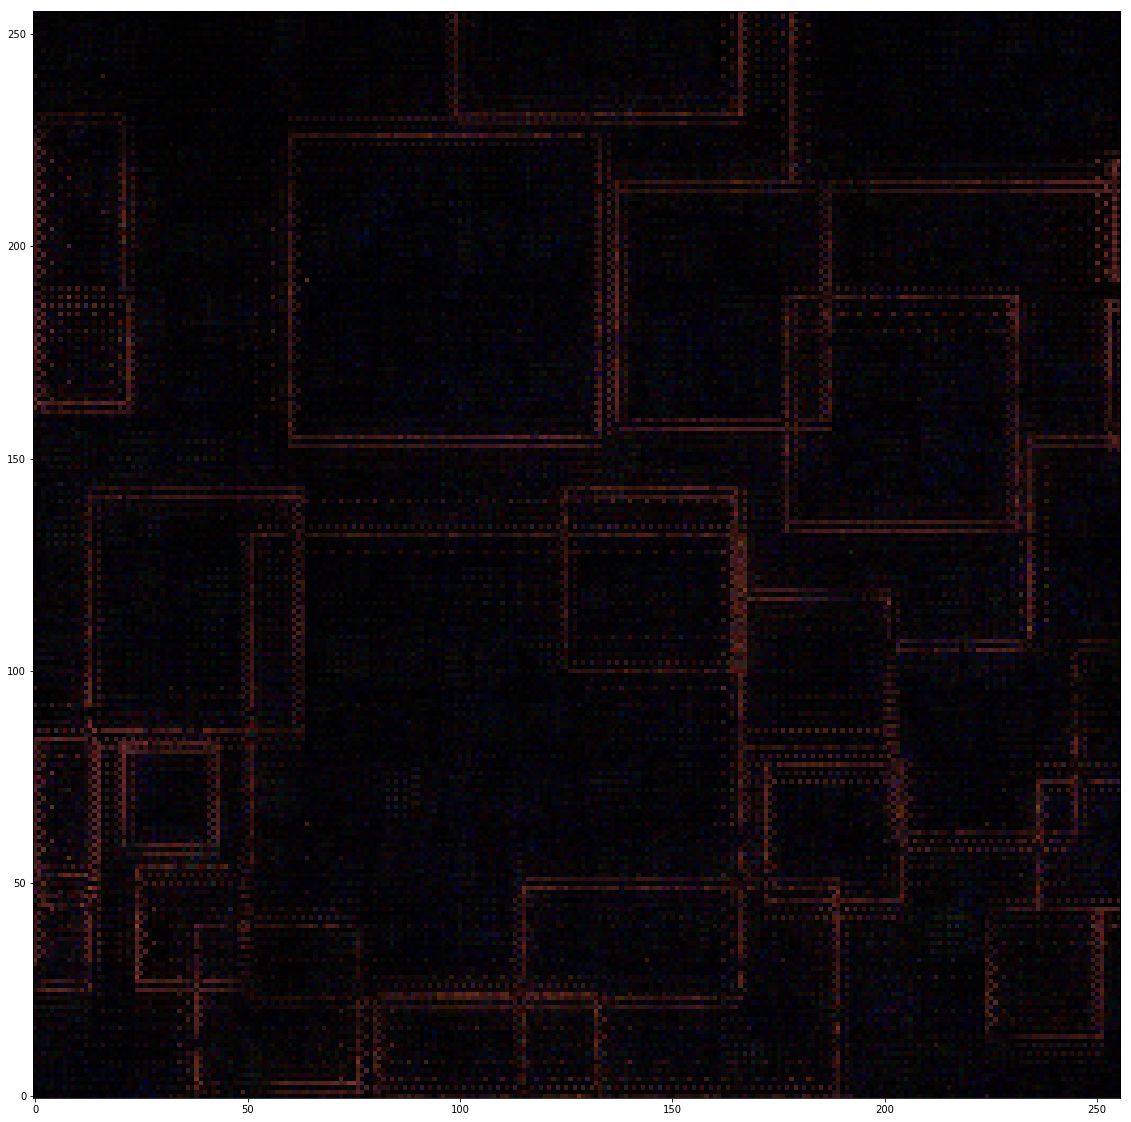

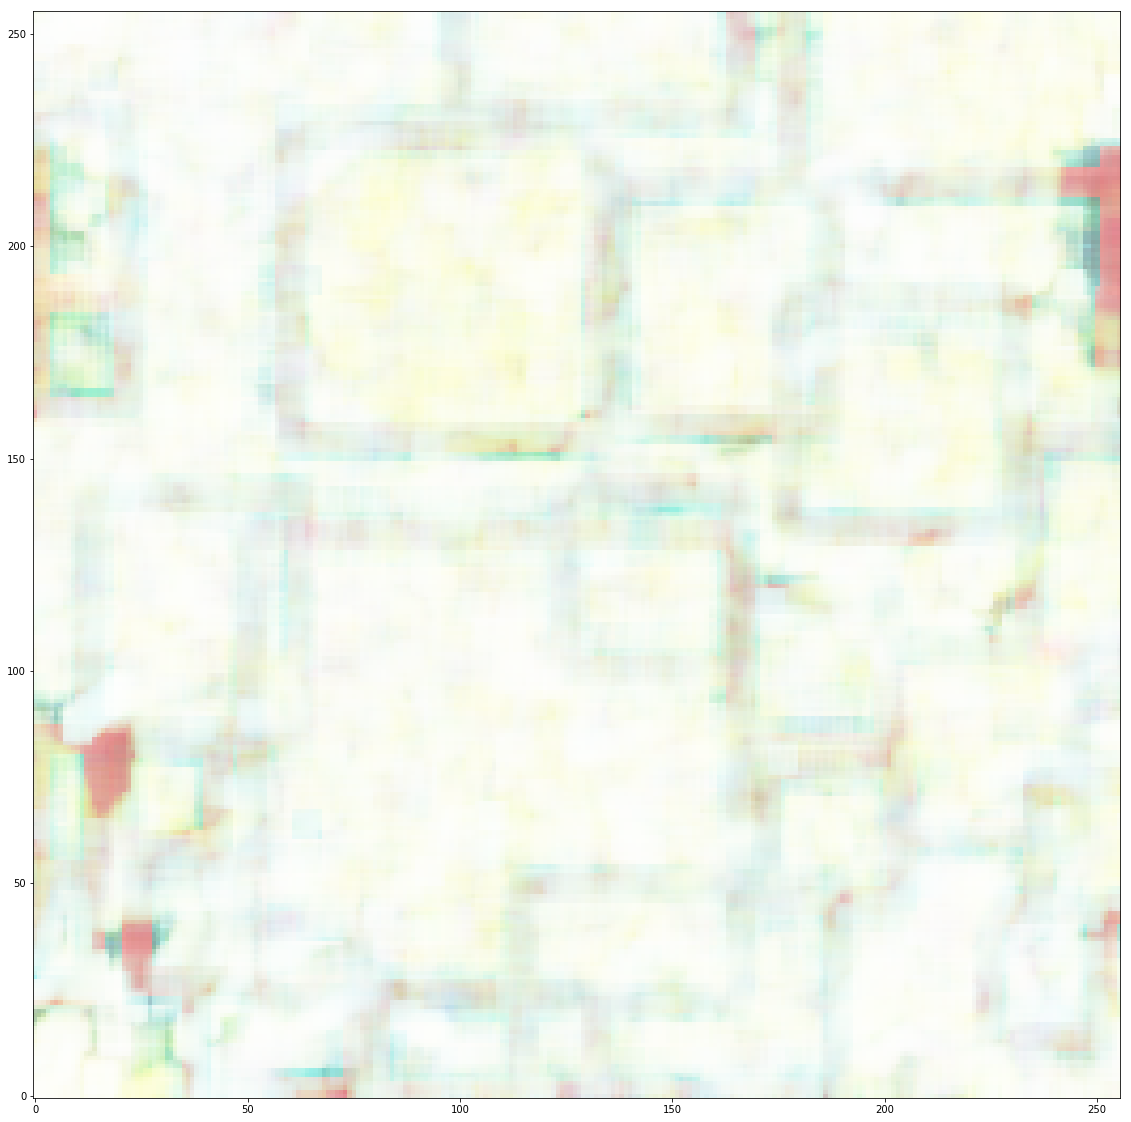

In [15]:
TestCompression(["jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE"],data=src)

### jpeg superb. Good quality but file too big.

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 2.45
RMSE (preview): 4.604226688782027
diff [min, max, mean]: [0, 37, 3.596099853515625]
sm [min, max, mean]: [0.5862909760643077, 0.9996408321473265, 0.9818409531177646]


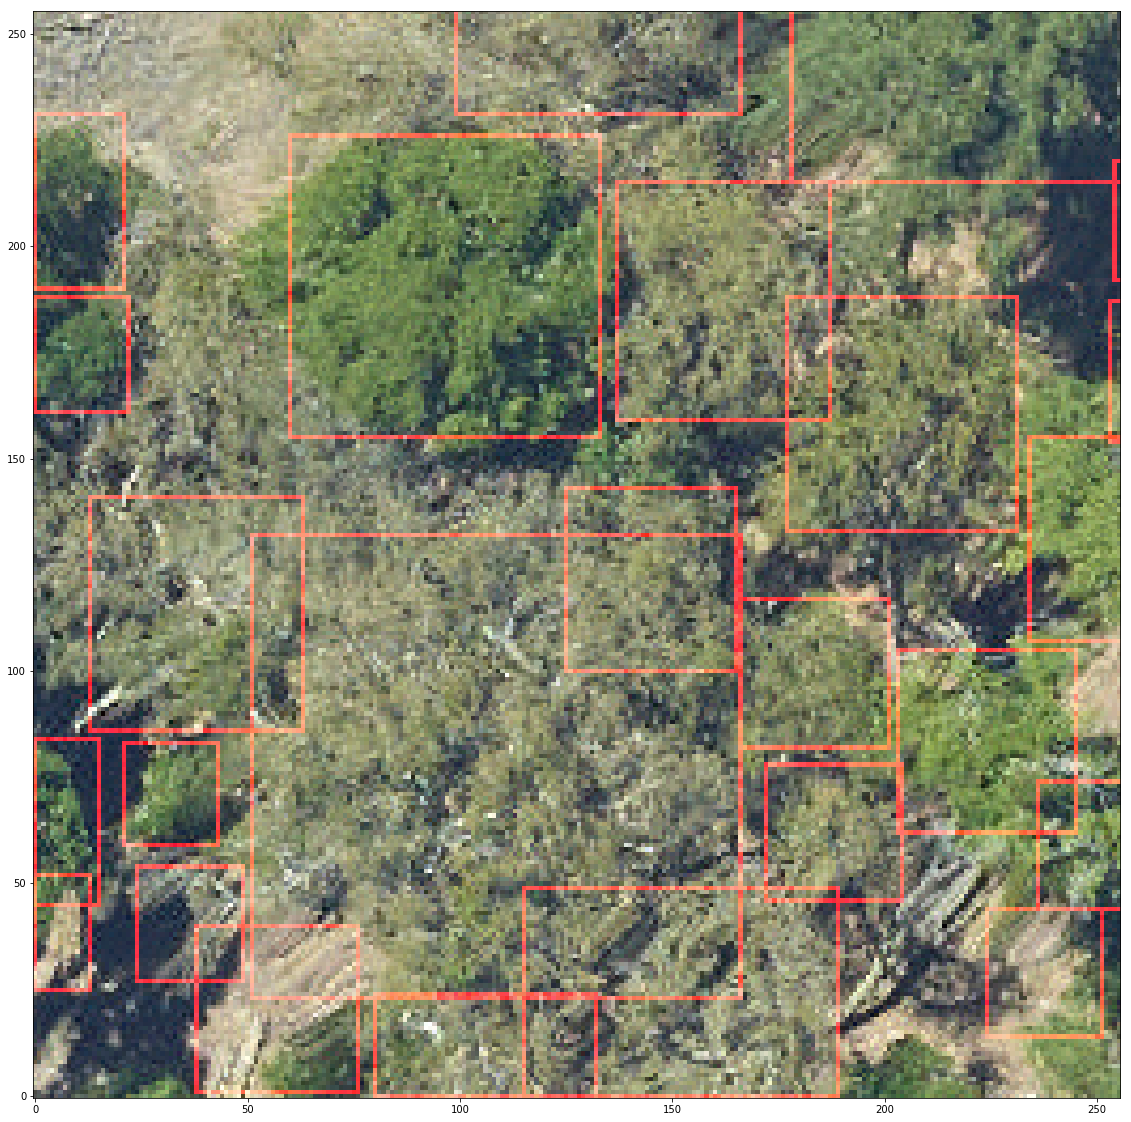

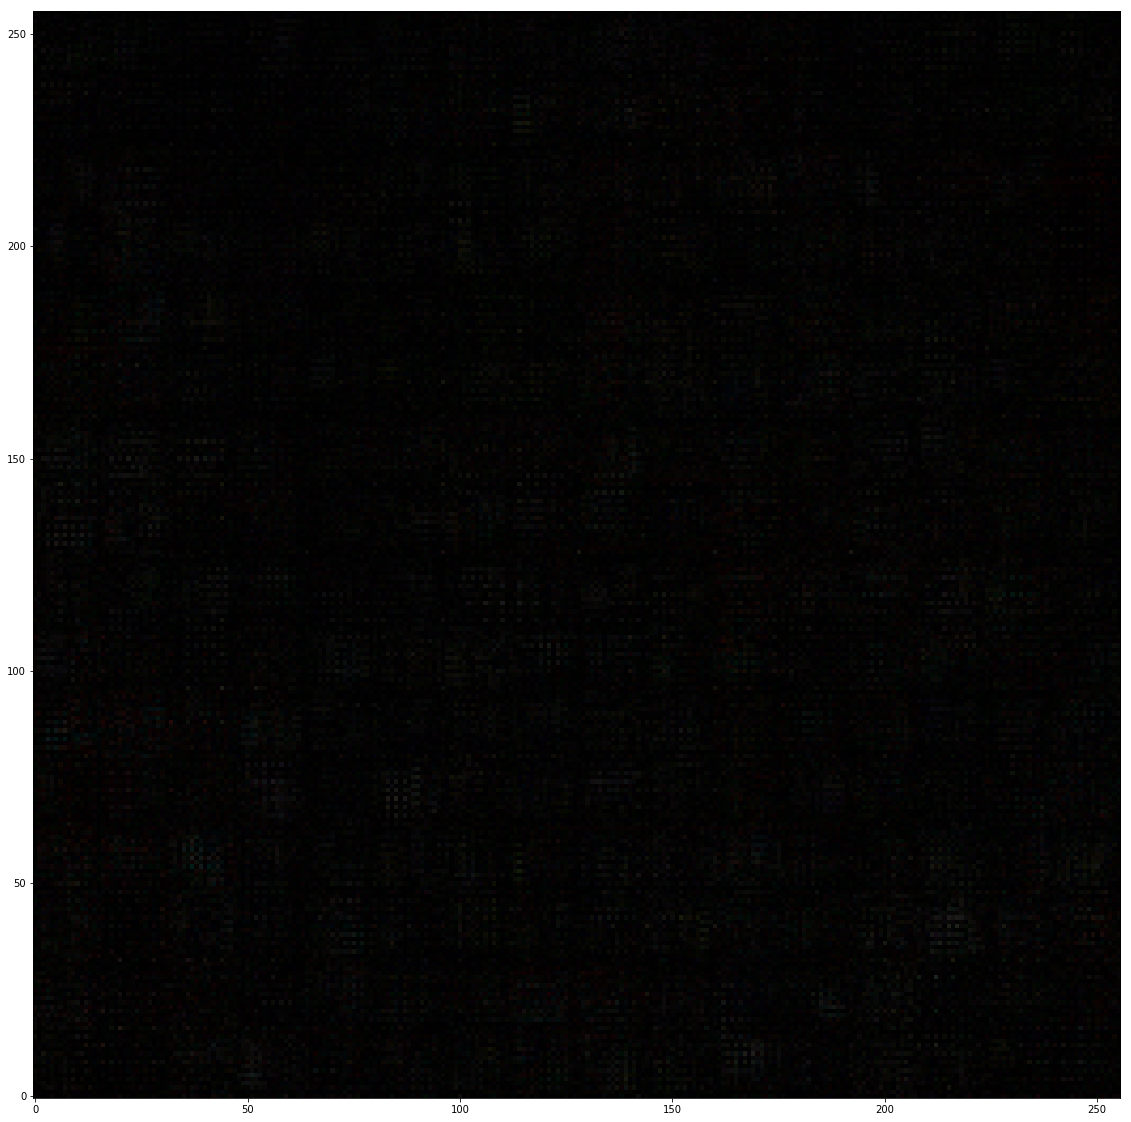

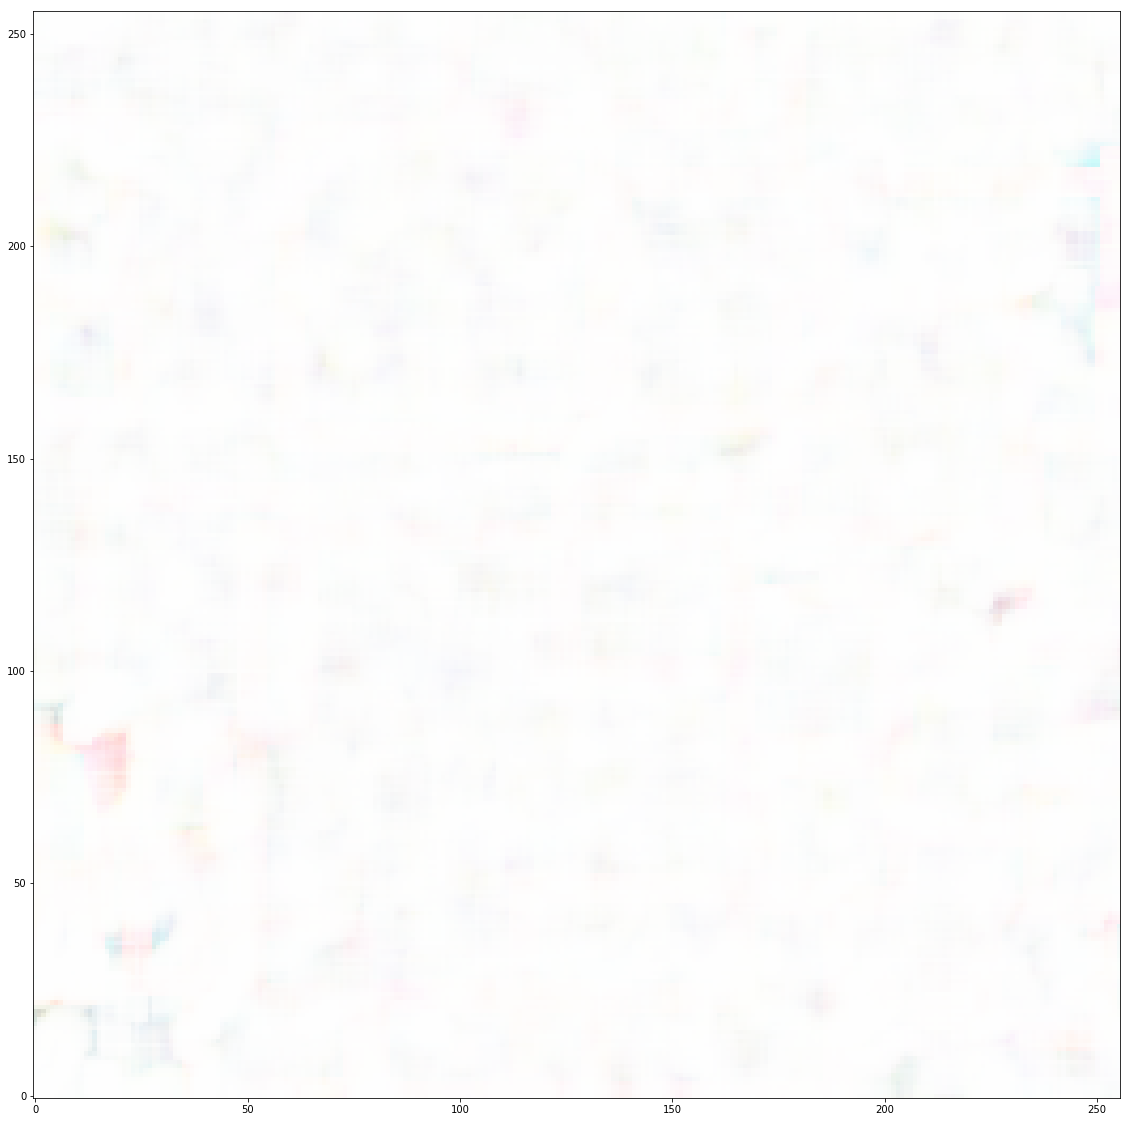

In [13]:
TestCompression(["jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE"],data=src)

### IDX Wavelet hoping for better zip compression. But compression is still bad.

Created db 9jtimifw.idx
Computing filter...
Compressing dataset...
Compression ratio in comparison to source data 3.19
RMSE (preview): 0.0
diff [min, max, mean]: [0, 0, 0.0]
sm [min, max, mean]: [1.0, 1.0, 1.0]


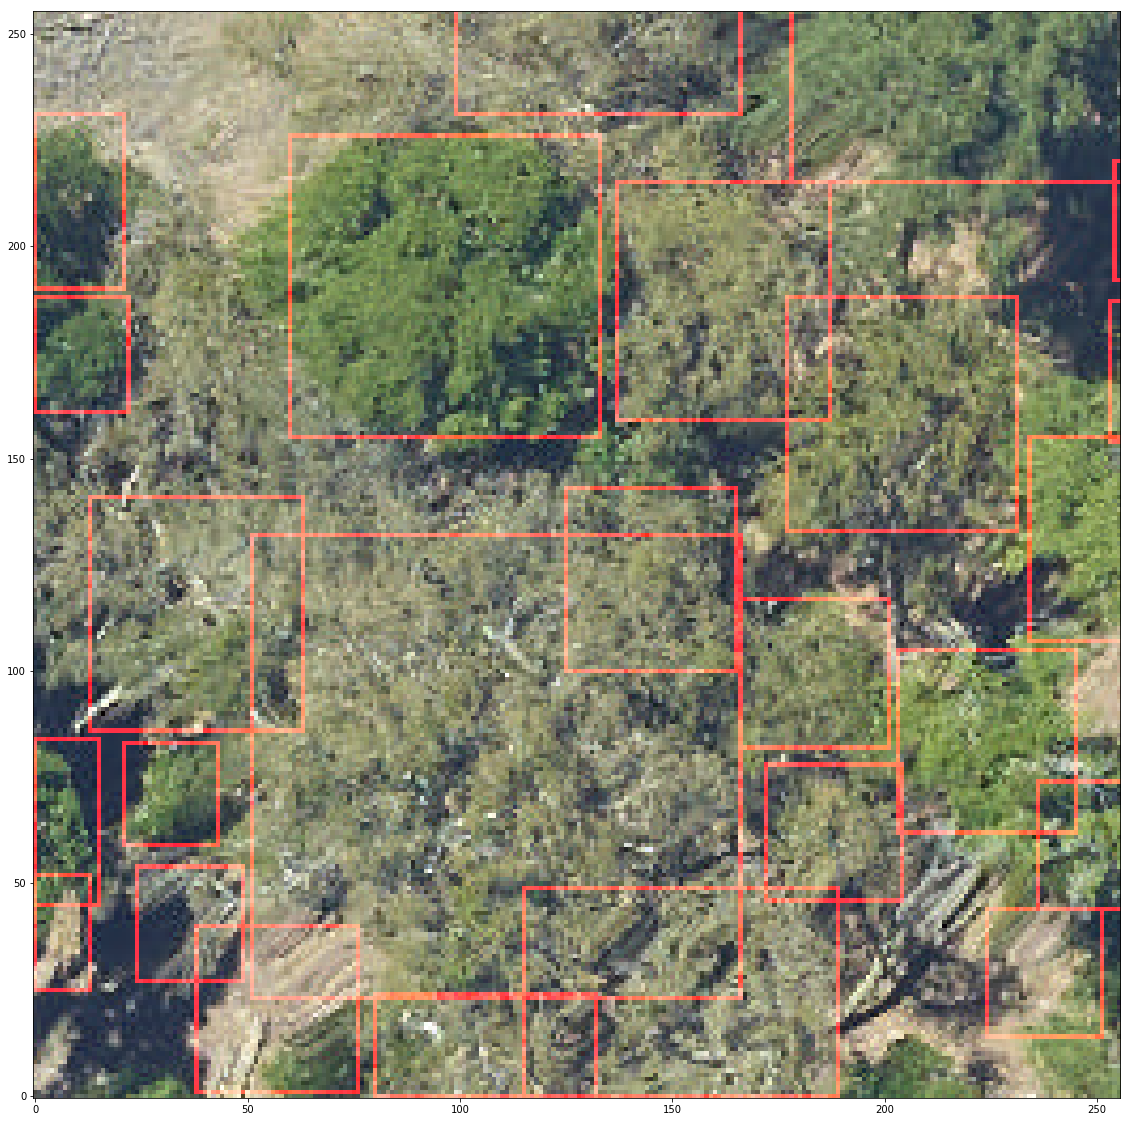

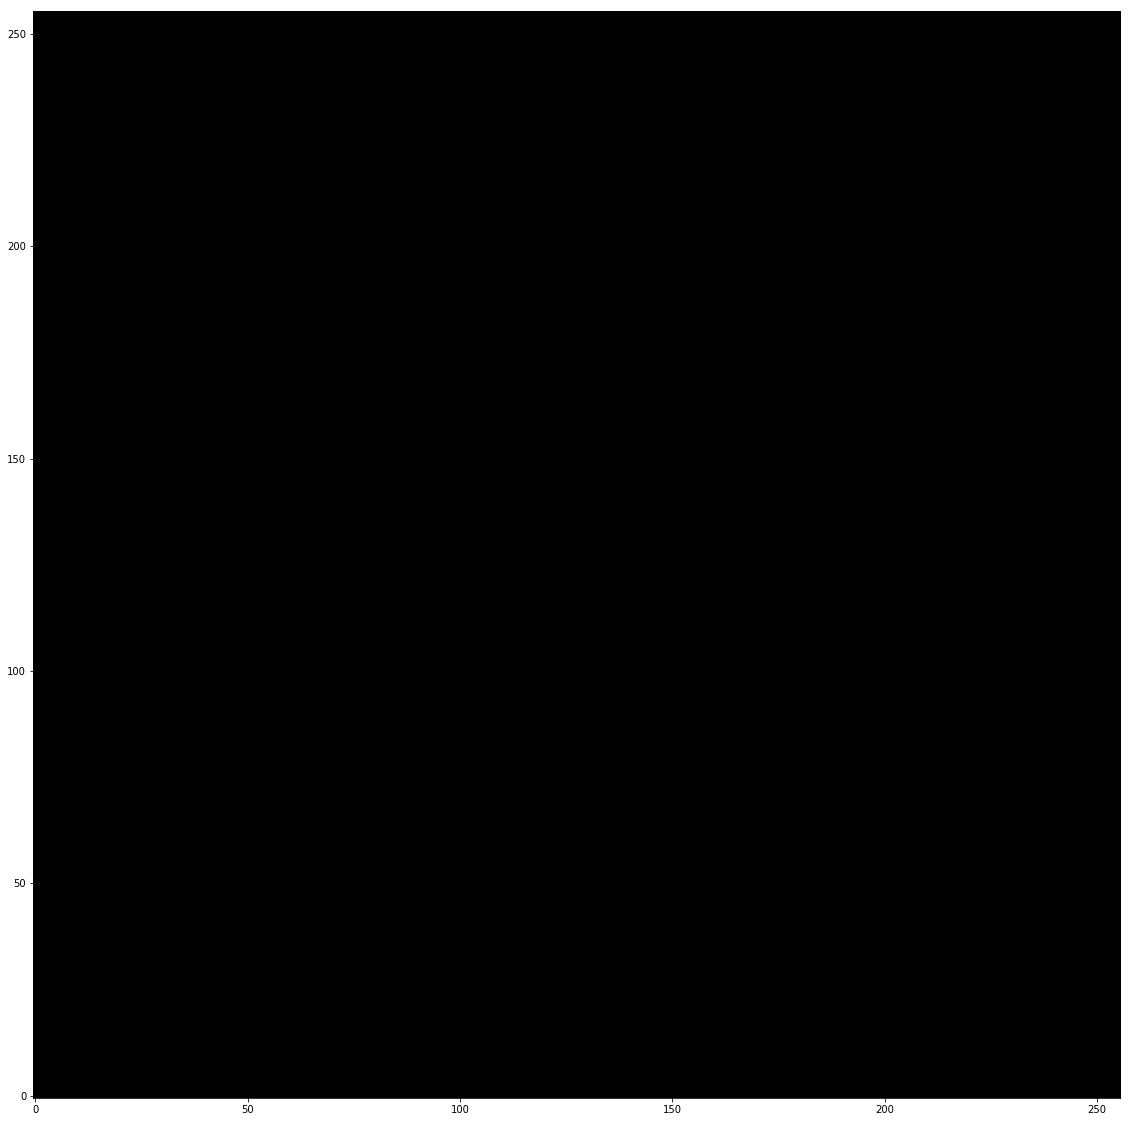

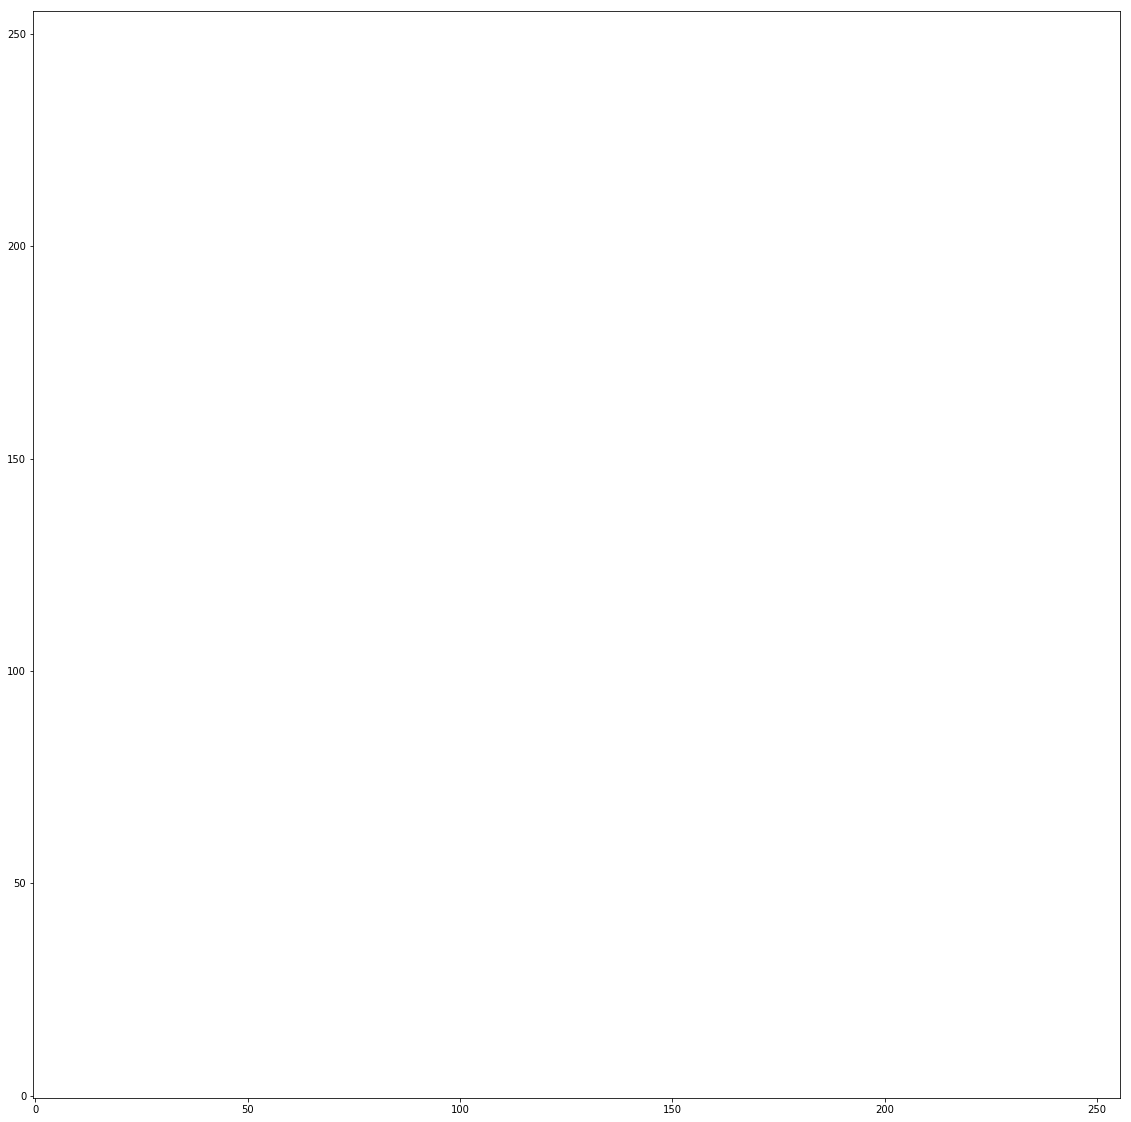

In [16]:
# i need an extra channel for wavelets coefficients
H,W,N=src.shape
Assert(N==3 and src.dtype==numpy.uint8)
rgbw=numpy.zeros((H,W,4),dtype=numpy.uint8)
rgbw[:,:,0:3]=src
TestCompression(["zip"],data=rgbw,filter="wavelet")

### Conclusion. Use JPEG only for last N-levels (i.e. you are sure about "vicinity")

Now it's possible to specify different compression for different levels. This example shows how to JPEG compress only last two levels; and compress all other levels using zip.

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 1.22
RMSE (preview): 6.9650533362557985
diff [min, max, mean]: [0, 100, 6.8665924072265625]
sm [min, max, mean]: [0.15349199579758757, 0.9989370902948886, 0.9100096156009245]


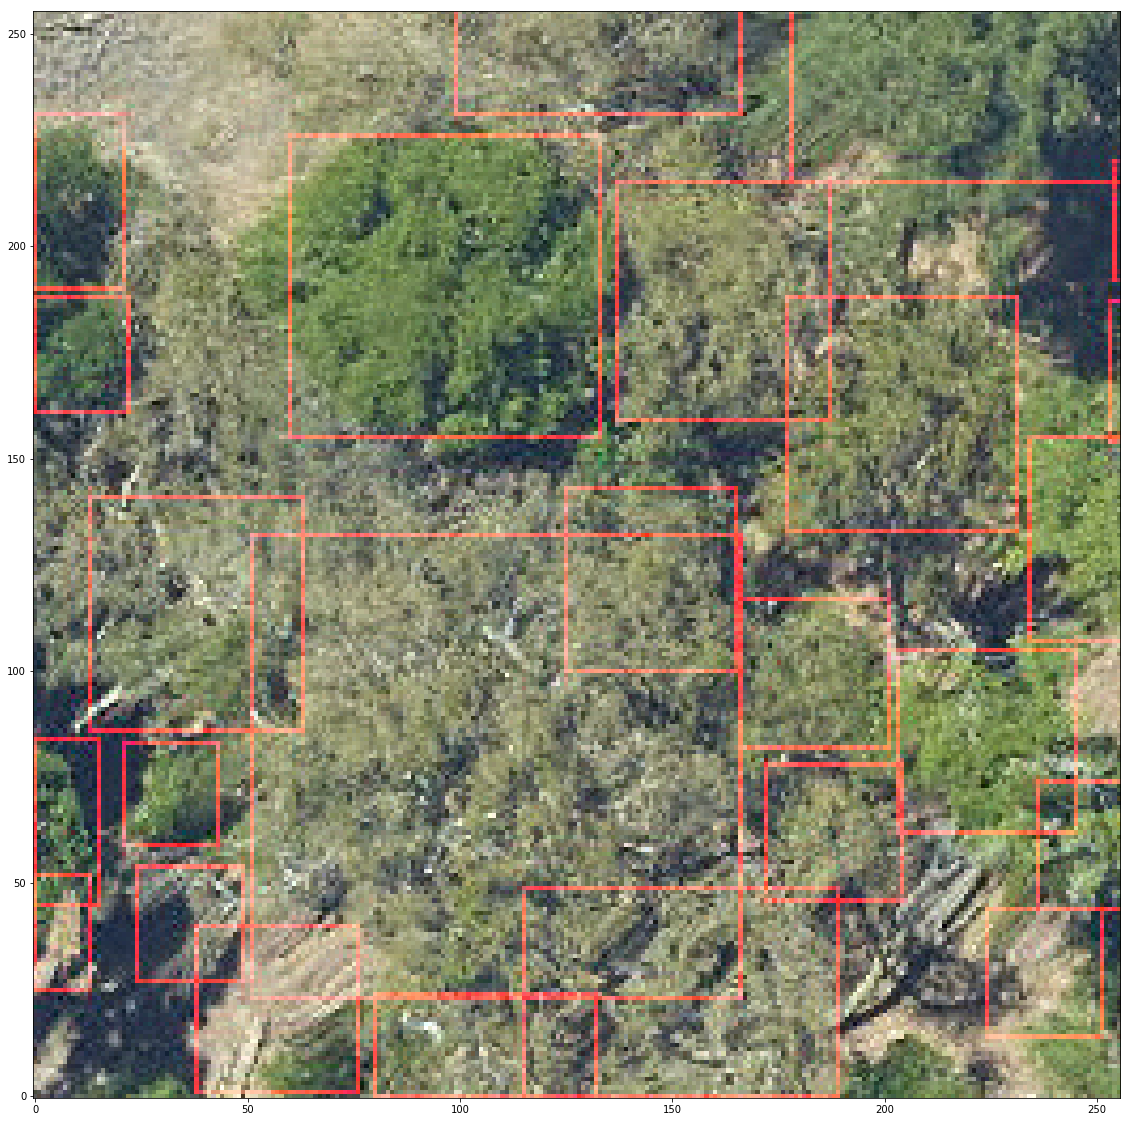

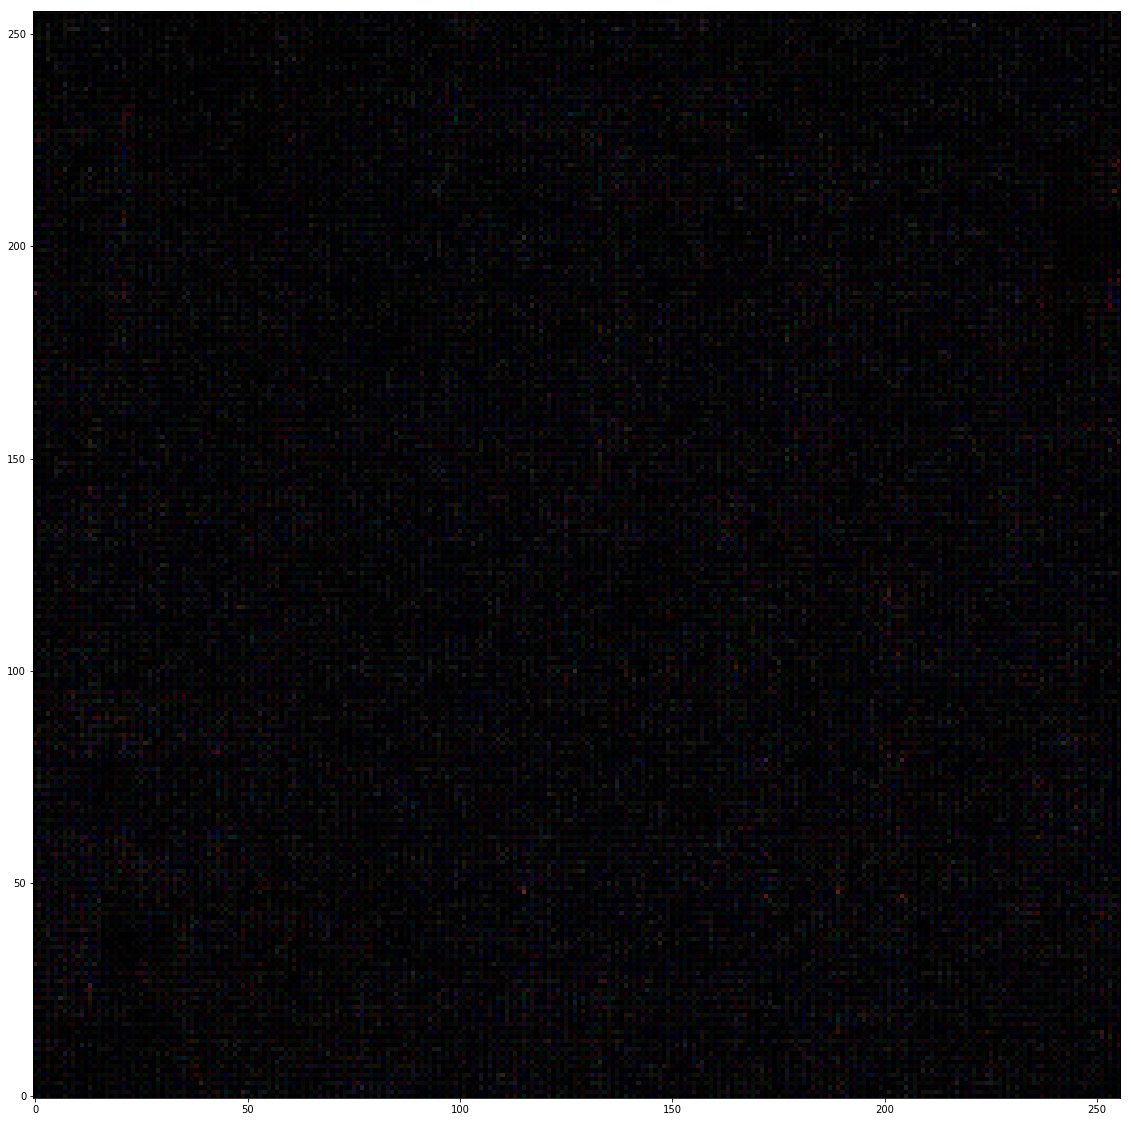

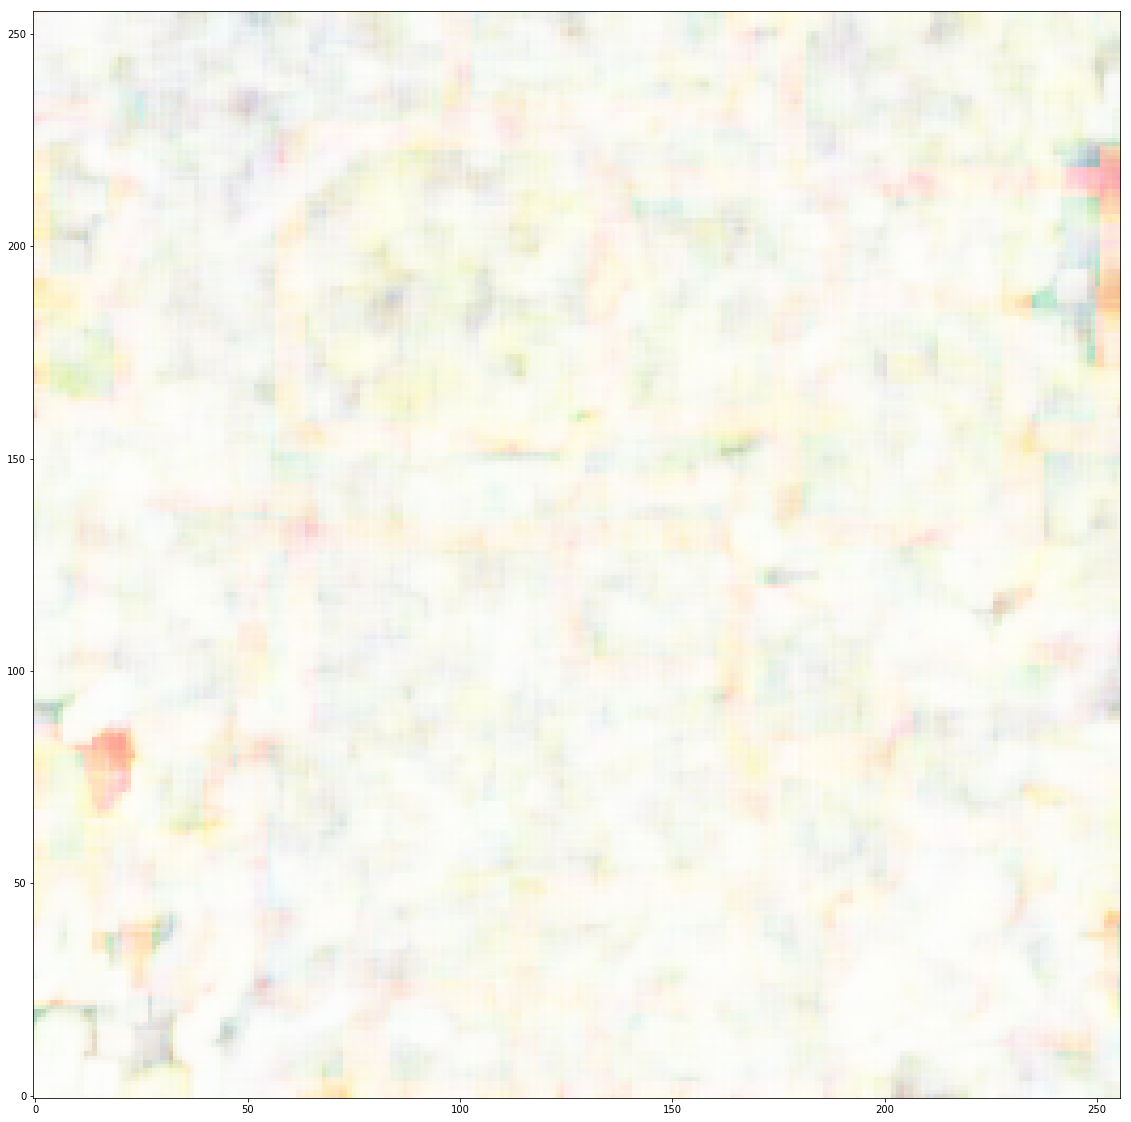

In [17]:
# last 2 levels jpeg
jpeg_good="jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE"
TestCompression(["zip",jpeg_good,jpeg_good],data=src)

Created db 9jtimifw.idx
Compressing dataset...
Compression ratio in comparison to source data 0.89
RMSE (preview): 7.553027733694848
diff [min, max, mean]: [0, 101, 8.098673502604166]
sm [min, max, mean]: [0.15078613354601805, 0.9982692380723888, 0.8947990880499092]


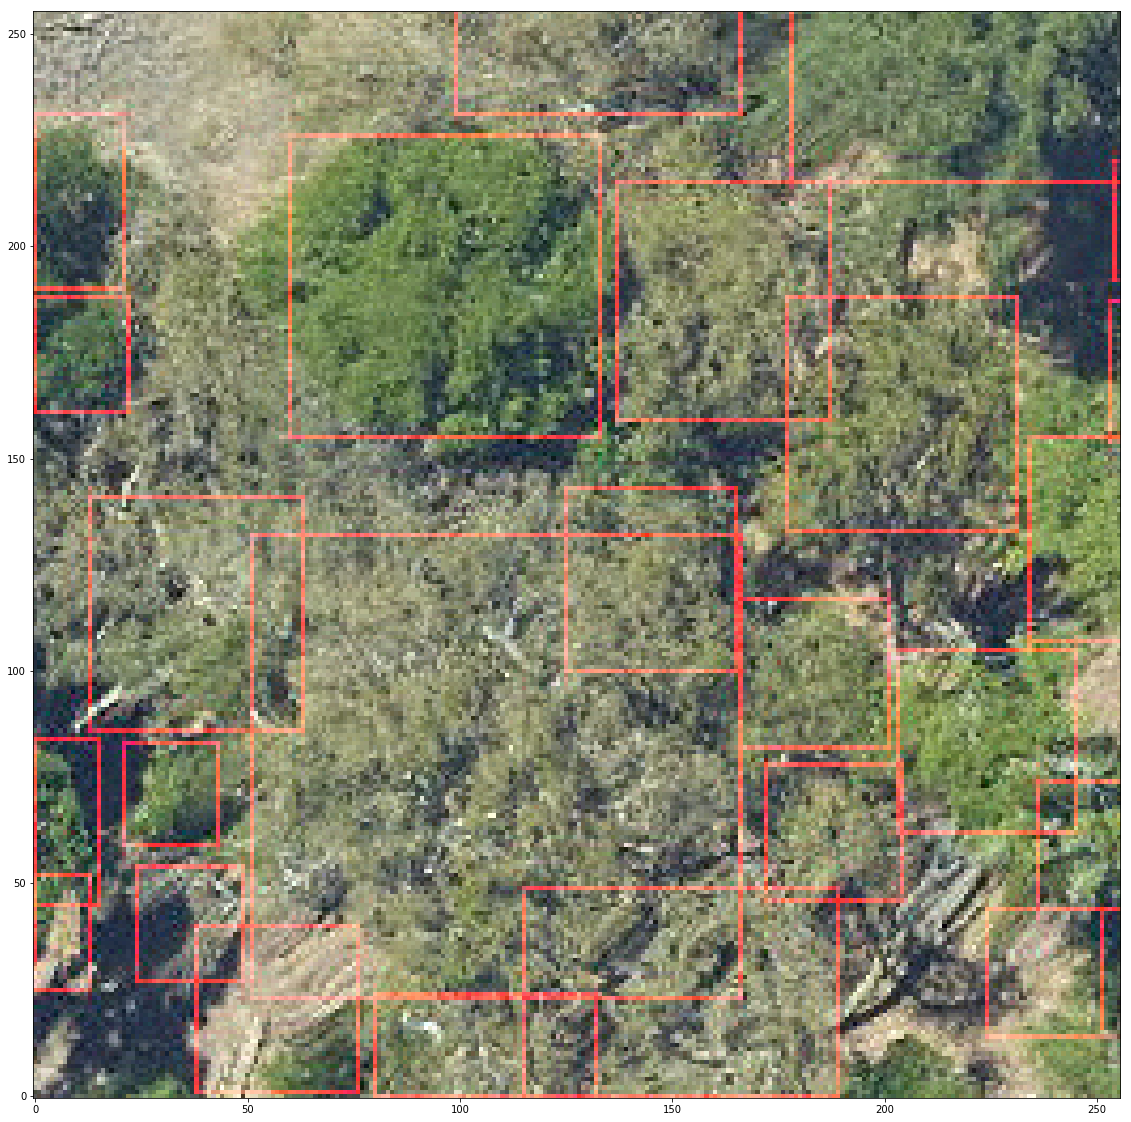

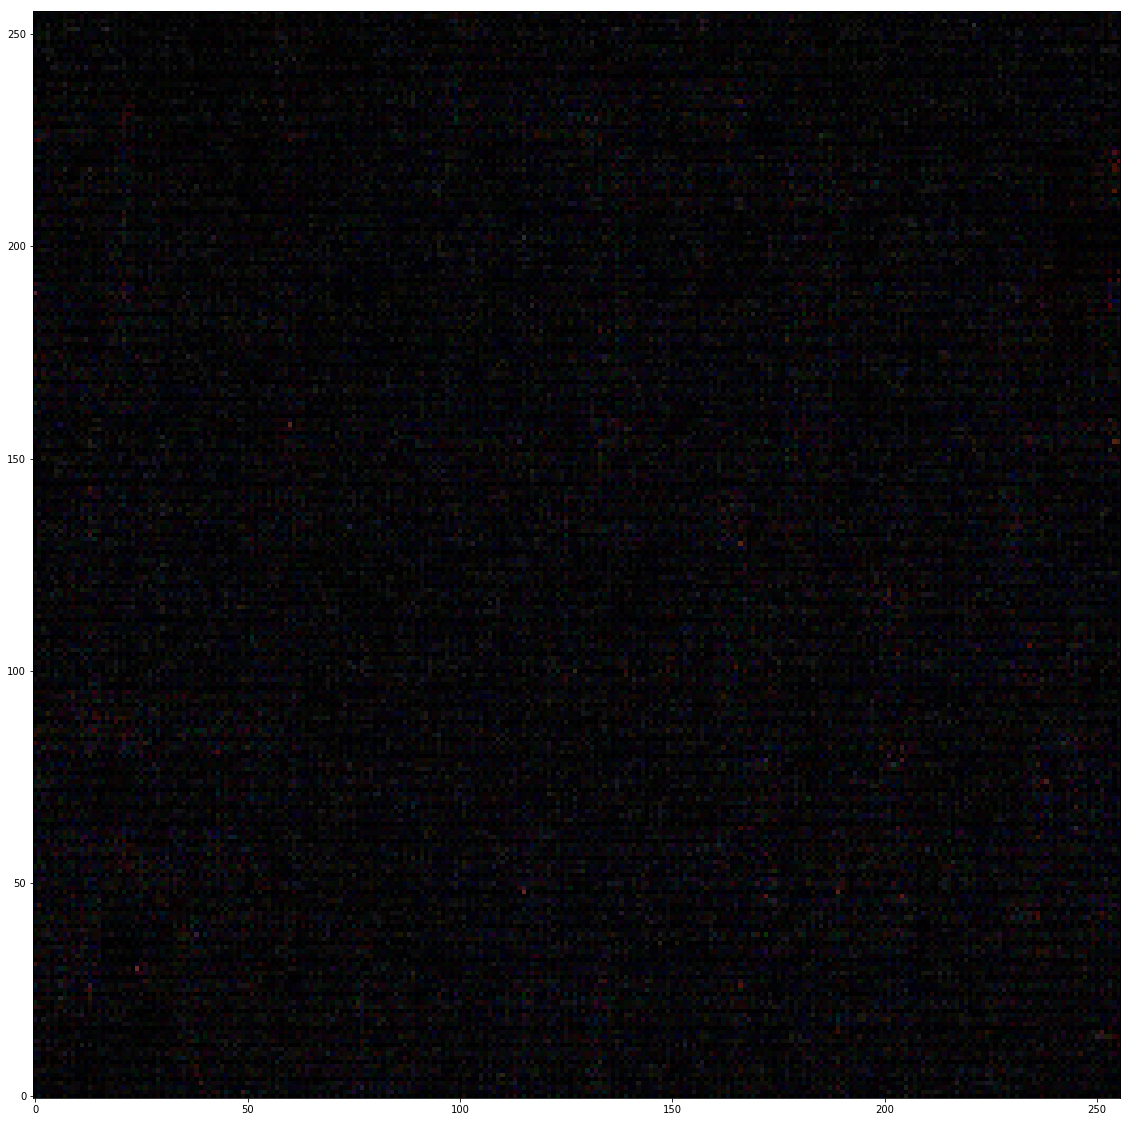

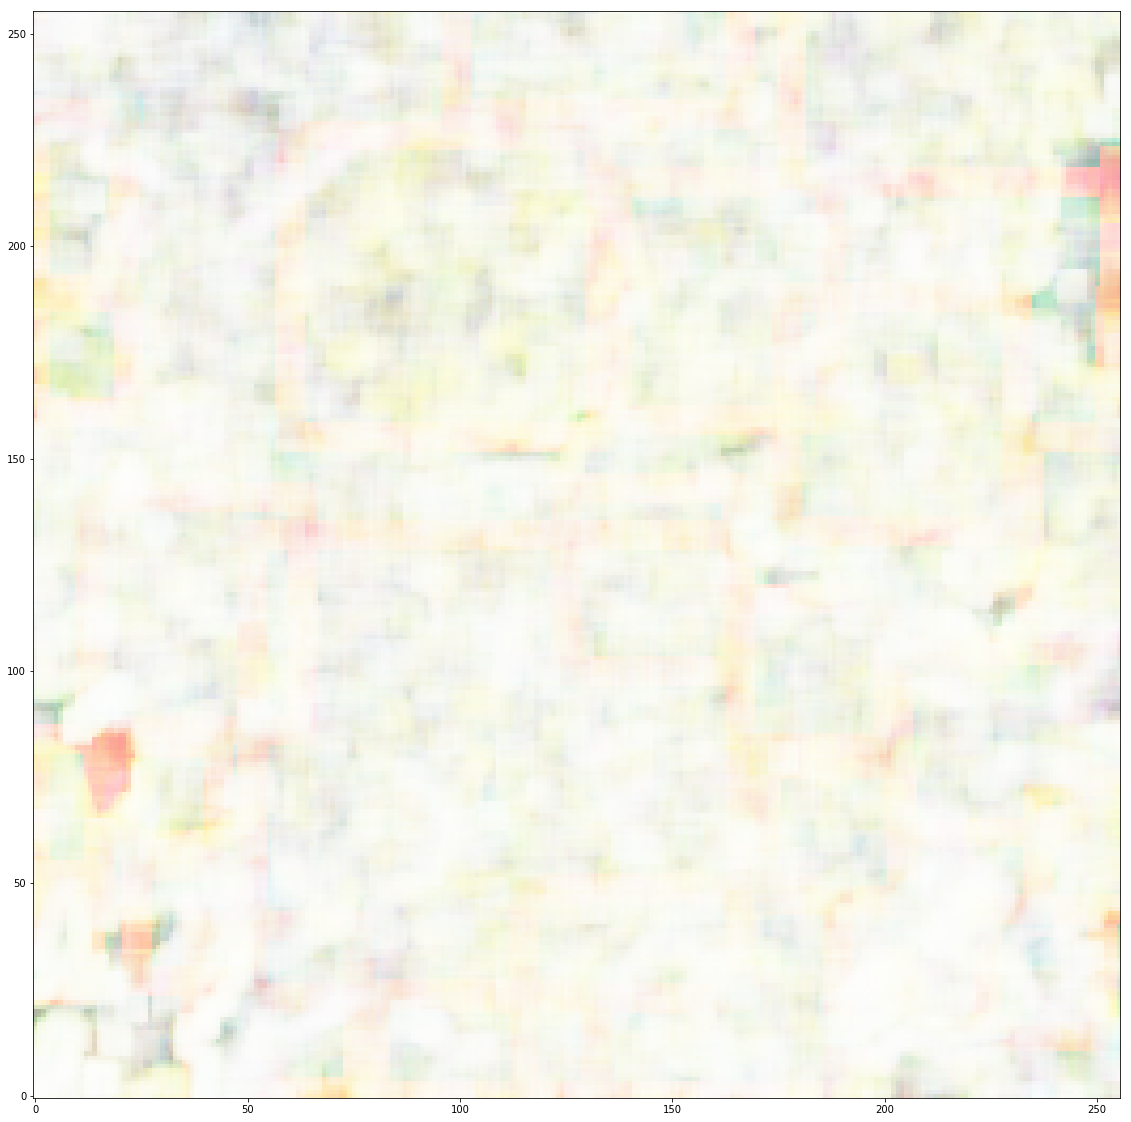

In [18]:
# last 3 levels jpeg
jpeg_good="jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE"
TestCompression(["zip",jpeg_good,jpeg_good,jpeg_good],data=src)